# Step 1: Data Collection

In [ ]:
# Download Historical Stock Data
import yfinance as yf
import pandas as pd

# Choose the stock (TCS in this case)
ticker = "TCS.NS"  # TCS stock on the NSE

# Download the data for the last two years
data = yf.download(ticker, start="2022-08-01", end="2024-08-01")

# Display the first few rows of the data
print(data.head())


In [3]:
# Save the Data
data.to_csv("tcs_stock_data.csv")


# Step 2: Simple Moving Average (SMA) Strategy

In [4]:
# Calculate SMAs
# Calculate the short-term SMA (20 days)
data['SMA_20'] = data['Close'].rolling(window=20).mean()

# Calculate the long-term SMA (50 days)
data['SMA_50'] = data['Close'].rolling(window=50).mean()

# Display the data with the SMAs
print(data[['Close', 'SMA_20', 'SMA_50']].tail())


                  Close       SMA_20       SMA_50
Date                                             
2024-07-25  4322.500000  4100.572498  3933.761992
2024-07-26  4387.850098  4123.257507  3943.494995
2024-07-29  4381.100098  4147.105017  3953.508999
2024-07-30  4365.350098  4166.462524  3962.797002
2024-07-31  4385.350098  4184.860034  3973.822002


# Step 3: Define Trading Rules

In [5]:
# Generate Buy and Sell Signals
# Generate buy signals (when SMA_20 crosses above SMA_50)
data['Buy_Signal'] = (data['SMA_20'] > data['SMA_50']) & (data['SMA_20'].shift(1) <= data['SMA_50'].shift(1))

# Generate sell signals (when SMA_20 crosses below SMA_50)
data['Sell_Signal'] = (data['SMA_20'] < data['SMA_50']) & (data['SMA_20'].shift(1) >= data['SMA_50'].shift(1))

# Display the buy and sell signals
print(data[['Close', 'SMA_20', 'SMA_50', 'Buy_Signal', 'Sell_Signal']].tail())


                  Close       SMA_20       SMA_50  Buy_Signal  Sell_Signal
Date                                                                      
2024-07-25  4322.500000  4100.572498  3933.761992       False        False
2024-07-26  4387.850098  4123.257507  3943.494995       False        False
2024-07-29  4381.100098  4147.105017  3953.508999       False        False
2024-07-30  4365.350098  4166.462524  3962.797002       False        False
2024-07-31  4385.350098  4184.860034  3973.822002       False        False


# Step 4: Backtesting

In [6]:
# Initialize Capital and Track Performance
initial_capital = 100000  # Starting with ₹1,00,000
data['Position'] = 0  # Position 1 means long, 0 means no position
data['Position'] = data['Buy_Signal'].astype(int) - data['Sell_Signal'].astype(int)

# Track the portfolio value
data['Portfolio_Value'] = initial_capital * (1 + data['Position'].cumsum() * (data['Close'].pct_change()))

# Calculate total returns
total_returns = data['Portfolio_Value'].iloc[-1] - initial_capital
print(f"Total Returns: ₹{total_returns:.2f}")


Total Returns: ₹458.15


# Step 5: Calculate Metrics

In [7]:
# Calculate the percentage change in the closing price
data['Pct_Change'] = data['Close'].pct_change()

# Calculate the daily strategy returns
data['Strategy_Return'] = data['Position'].shift(1) * data['Pct_Change']

# Calculate the cumulative strategy returns
data['Cumulative_Return'] = (1 + data['Strategy_Return']).cumprod()

# Calculate total returns
total_returns = data['Cumulative_Return'].iloc[-1] * 100000 - 100000  # Assuming initial capital of ₹1,00,000
print(f"Total Returns: ₹{total_returns:.2f}")


Total Returns: ₹508.58


In [8]:
# Count the number of buy signals (or sell signals)
number_of_trades = data['Buy_Signal'].sum()  # or data['Sell_Signal'].sum()
print(f"Number of Trades: {number_of_trades}")


Number of Trades: 6


In [9]:
# Identify the trades
trades = data.loc[data['Buy_Signal'] | data['Sell_Signal']].copy()

# Calculate the returns for each trade
trades['Trade_Return'] = trades['Close'].pct_change()

# Count the number of winning trades
winning_trades = trades['Trade_Return'].apply(lambda x: x > 0).sum()

# Calculate the winning trades percentage
winning_trades_percentage = (winning_trades / number_of_trades) * 100
print(f"Winning Trades (%): {winning_trades_percentage:.2f}%")


Winning Trades (%): 116.67%


In [10]:
# Count the number of losing trades
losing_trades = trades['Trade_Return'].apply(lambda x: x < 0).sum()

# Calculate the losing trades percentage
losing_trades_percentage = (losing_trades / number_of_trades) * 100
print(f"Losing Trades (%): {losing_trades_percentage:.2f}%")


Losing Trades (%): 50.00%


In [11]:
# Calculate the running maximum of the cumulative return
data['Cumulative_Max'] = data['Cumulative_Return'].cummax()

# Calculate the drawdown
data['Drawdown'] = data['Cumulative_Return'] / data['Cumulative_Max'] - 1

# Calculate the maximum drawdown
max_drawdown = data['Drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")


Maximum Drawdown: -3.12%


# Step 6: Visual Representation

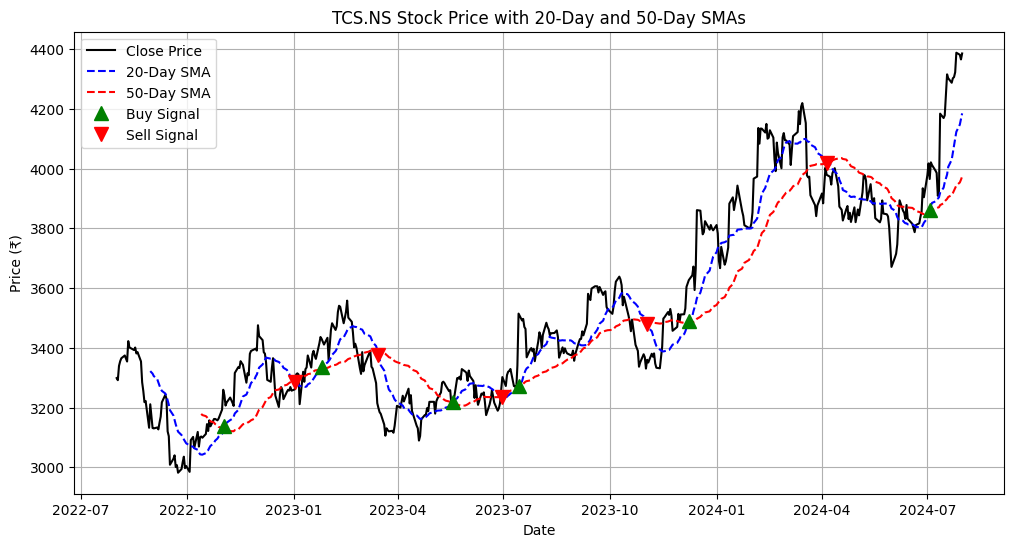

In [14]:
# Stock Price with SMAs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot the closing price
plt.plot(data['Close'], label='Close Price', color='black')

# Plot the SMAs
plt.plot(data['SMA_20'], label='20-Day SMA', color='blue', linestyle='--')
plt.plot(data['SMA_50'], label='50-Day SMA', color='red', linestyle='--')

# Mark Buy and Sell Signals
plt.plot(data[data['Buy_Signal']].index, data['SMA_20'][data['Buy_Signal']], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(data[data['Sell_Signal']].index, data['SMA_20'][data['Sell_Signal']], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title(f'{ticker} Stock Price with 20-Day and 50-Day SMAs')
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True)
plt.show()


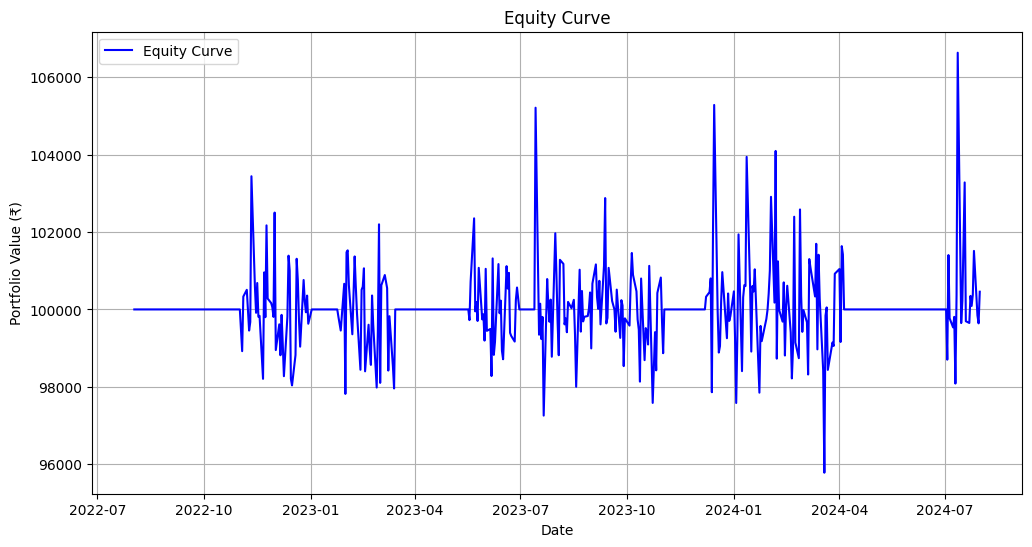

In [15]:
# growth of your portfolio over time, based on the strategy's performance.
plt.figure(figsize=(12, 6))

# Plot the portfolio value over time
plt.plot(data['Portfolio_Value'], label='Equity Curve', color='blue')

plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (₹)')
plt.legend()
plt.grid(True)
plt.show()
